# Q-Learning and Sparse Incremental Feature Dependency Discovery (iFDD) on discrete Swimmer-v1
### Relevant Documents 
- **Senior Design**: [Final Report](http://nbviewer.jupyter.org/github/huanntran100/Miscellaneous-/blob/master/Group%2012%20Q-Learning%20and%20IFDD%20Final%20Report%20%281%29.pdf)
- **RL Algorithm**: [Q-Learning](https://en.wikipedia.org/wiki/Q-learning) 
- **MIT's Feature Generalization Algorithm**: [Incremental Feature Dependency Discovery](http://people.csail.mit.edu/agf/Homepage/Research/Entries/2011/12/13_Incremental_Feature_Dependency_Discovery.html)
- **Environment**: [Swimmer-v1](https://gym.openai.com/envs/Swimmer-v1/) (3-link, 2-joint snake robot)
- Due to the discrete nature of the Q-learning algorithm and feature representation, I naively discretize the state space to whole number observations between -5 and 5, and the action space to [-0.36, 0, and 0.36] degrees.


### Introduction
- This personal project is meant as an improvement or update of my Bioengineering senior design project, as well as a light investigation the rate or frequency of online feature discovery in terms of reducing learning variance and increasing training speed, the former of which is visually seen as sharp changes in cumulative reward over time. Although the research paper on iFDD itself is old, it was good practice for me to code the algorithm from scratch (I also couldn't find the Github or any tutorial online to double check). I learned how to implement vanilla and adaptive Q-learning linear approximation, as well as derive similar results to the paper but on an untested environment.   

- In the senior design project, we demonstrated statistically significant improvement in locomoted distance (or cumulative reward) of Q-Learning w/ iFDD over a random policy for a 2-jointed robotic snake in Unity3D over at 500,000 time steps. However, we failed to convincingly demonstrate a difference between vanilla Q-Learning vs. Q-Learning w/ iFDD, or visually demonstrate feature generalization at any point during the episode due to the high standard deviation of our iFDD algorithm implementation.   

- Therefore, the motivation for this small project is to bring more closure to the senior project. I expect to get similar results to the paper's pendulum problem, where Q-Learning w/ and w/o iFDD both perform nearly the same, with the latter having a slight but significant advantage. 

### Scope & Goal
- In this project, **the task of the discrete Swimmer agent is to learn to locomote online in the forward direction for a single episode without any prior knowledge of the environment or handcrafted locomotion policy.** A successfully learned action-value function is shown as consistent movement in the forward direction. In the case of the Swimmer environment, this is consistently accumulating positive reward over the episode. 

- **Q-Learning is used over SARSA pedagogically for this project.** In reality, SARSA may be better due to the need of robotic learning to be on-policy for safety reasons. Being on-policy, SARSA chooses to update the weights in the direction of the value of the action it actually takes. Q-Learning, which is off-policy, is "optimistic" as an algorithm due to its "max" operation over the possible next actions, regardless of the action it takes; this is potentially dangerous because the agent might make decisions leading to a bad trajectory over time. 

- Thus, while there are related problems that involve reusing learned weights and feature sets across multiple episodes, the original goal of the senior design project was to achieve learning in a single episode, as if in a real world environment.

### Modifications to iFDD
- Here, I reimplemented the project in Python and Mujoco on the similar Swimmer-v1 environment, and I aim to improve upon the results of the senior design project by showing a clearer difference between the algorithms. In the Python implementation, one of the first things I noticed was that vanilla linear Q-Learning function approximation either did really well or really poorly. Sometimes, the agent will learn a good policy for locomoting forward for the entire episode. Other times, the function will diverge catastrophically, shown as sharp, abrupt fluctuations or consistent movement in the negative direction.  

- I test a single idea to attempt to address all the above problems. By reducing the discovery frequency over the length of the single episode, and sparsely sampling potentially discoverable features (hence "Sparse iFDD"), the agent is still able to generalize faster earlier on, while maintaining adequate computational speed later as more and more features being added to the representation. Furthermore, this appears to stabilize Q-Learning by giving time for the agent to update the newer weights and converge towards the optimal action-value function for that particular feature set, without having to experience a constant, growing feature expansion which slows down learning progress in realtime. 

- Potential issues with this project is that my computer is probably too slow, and some elements of my iFDD implementation may be inefficiently coded. I will continue to improve this project. 

### Summary of Swimmer-v1 Environment
I run the environment randomly to display the raw observations and actions output.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 

import gym
import numpy as np
import time
import tensorflow as tf
import itertools
from itertools import chain
from itertools import combinations

# Setting up the Swimmer-v1 environment
env = gym.make('Swimmer-v1')
env.reset()
for _ in range(50):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if _ % 25 == 0:
        for i in range(len(observation)):
            observation[i] = observation[i]
        print('Example of observation:', observation)
        print('Example of action:', action)

[2018-01-05 10:32:51,622] Making new env: Swimmer-v1


Example of observation: [ 0.03062318 -0.00812408  0.11019318 -0.07773705 -0.11730524  0.14242939
 -0.36568468  0.82559156]
Example of action: [ 0.09762701  0.43037873]
Example of observation: [ 0.5356533  -1.27902224  1.54218535  0.35744839 -0.48103319  0.67052644
 -0.57633949 -1.23459   ]
Example of action: [ 0.14039354 -0.12279697]


### Q-Learning and Sparse iFDD Algorithm
The following algorithm presented in this notebook is completely based on MIT's paper on [Incremental Feature Dependency Discovery](http://people.csail.mit.edu/agf/Homepage/Research/Entries/2011/12/13_Incremental_Feature_Dependency_Discovery.html) from 2011. Please refer to the paper for more information on iFDD itself. For this report, the following additions were made in response to Q-learning divergence issues I encountered with the discretized Swimmer environment: 
- **Relevance Update Frequency**: using the mathematical MOD function (seen as **(d mod t) == 0** in the code) and doubling the frequency (seen as **d+=d**) every time the discovery algorithm is executed, the relevances of undiscovered features are now updated at progressively lower frequencies over the episode, as opposed to every timestep in the original paper. During early experimentation with iFDD, I saw that if features were added too quickly, the learning diverged and forward locomotion was not achieved in the same time as vanilla Q-Learning.
- **Discovery Probability**: even if a feature's relevance exceeds the threshold, the feature has a probability of GAMMA of not being discovered right away. Again, this is to prevent features from being added too quickly.
- **Adding Previously Unencountered Features**: unencountered features are added to the undiscovered feature set with a probability of THETA. Having too many features in the undiscovered feature set at once increased computational time to the point where training would theoretically take days, which is opposite of the goal of this algorithm.
- **Epsilon-Greedy incrementation**: epsilon is incremented slowly over the episode to reflect the agent becoming more greedy with its action selection as it improves learning and generalization. This is also to prevent too many new features from being encountered too frequently, and encourage the weight-updates among existing discovered features.

Overall, the rate at which features are discovered and added for relevance tracking are decreased significantly in order to stabilize Q-learning. Otherwise, the main idea of original iFDD algorithm remains intact, such as increasing the size of the weights and basis function to account for nonlinearities and to reflect discovering features.  

The Sparse iFDD algorithm I describe is found [[here](https://github.com/huanntran100/Miscellaneous-/blob/master/Q-Learning%20with%20Sparse%20IFDD.PNG?raw=true)].

### Parameters and Features
**Features** are handcrafted, while hyperparameters (epsilon, threshold, gamma, theta, discount factor, learning rate) are selected emperically.  
- **Epsilon**: 0.01 += 0.0000001 per timestep 
- **Threshold**: 0.9 (roughly double of the max TD error seen in Q-Learning alone)
- **Gamma**= 0.001 (probability of discovering a feature)
- **Theta** = 0.0001 (probability of adding a previously unseen feature to the undiscovered set)
- **Discount Factor** = 0.001 (found by observing Q-Learning alone)
- **Learning Rate** = 0.001 (found by observing Q-Learning alone)


In [106]:
# Method Notebook for Q-Learning and Sparse iFDD
%run QSiFDD.ipynb

[2018-01-06 22:03:32,789] Making new env: Swimmer-v1


State Features: [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5] 
Action Features: [-0.036, 0.0, 0.036] 
Feature Map: [[-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-0.036, 0.0, 0.036], [-0.036, 0.0, 0.036]]


### Results
- We run 3 trials of single episodes of Q-Learning vs. Q-Learning w/ Sparse iFDD, initializing different initial active features each time. This is to demonstrate that Sparse iFDD is robust across different sets of initial features. We 
- Episode Length: 1,500,000 time steps
- Discovery Frequency: 600 += 600 every time the Sparse iFDD algorithm executes 

-------BEGIN 3 trials of Q-Learning vs. Q-Learning w/ Sparse iFDD for 1500000 episodes.-------
Trial: 1
Initial Active Features for Current Trial: [4, 12, 26, 36, 44, 57, 67, 81, 90, 91]
-----------Q-Learning-----------
Len Initial Discovered Set: 10 
Len Initial Undiscovered Set: 1013
Timestep: 0 Time elapsed: 0.01 Cumulative Reward: 0
Timestep: 500000 Time elapsed: 183.13 Cumulative Reward: -67.7803
Timestep: 1000000 Time elapsed: 362.14 Cumulative Reward: -110.3559
Timestep: 1500000 Time elapsed: 537.73 Cumulative Reward: -7.2958
Training Time: 537.73
-----------Q-Learning w/ Sparse iFDD-----------
Len Initial Discovered Set: 10 
Len Initial Undiscovered Set: 1013
Timestep: 0 Elapsed: 0.11 DISCOVERED: 10 UNDISCOVERED: 1013 Basis: 94 Weights: 94 Cumul. Reward: 0
Timestep: 500000 Elapsed: 373.16 DISCOVERED: 21 UNDISCOVERED: 1089 Basis: 105 Weights: 105 Cumul. Reward: 112.7262
Timestep: 1000000 Elapsed: 1974.52 DISCOVERED: 54 UNDISCOVERED: 1158 Basis: 138 Weights: 138 Cumul. Reward: 15

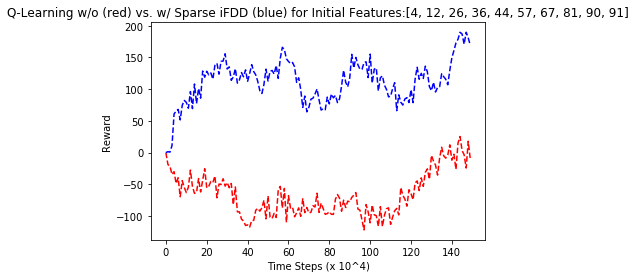

Time Elapsed: 4957.21
Trial: 2
Initial Active Features for Current Trial: [1, 14, 22, 33, 45, 59, 70, 78, 90, 93]
-----------Q-Learning-----------
Len Initial Discovered Set: 10 
Len Initial Undiscovered Set: 1013
Timestep: 0 Time elapsed: 0.01 Cumulative Reward: 0
Timestep: 500000 Time elapsed: 180.32 Cumulative Reward: -24.0471
Timestep: 1000000 Time elapsed: 384.33 Cumulative Reward: 68.2658
Timestep: 1500000 Time elapsed: 587.37 Cumulative Reward: 292.7604
Training Time: 587.37
-----------Q-Learning w/ Sparse iFDD-----------
Len Initial Discovered Set: 10 
Len Initial Undiscovered Set: 1013
Timestep: 0 Elapsed: 0.08 DISCOVERED: 10 UNDISCOVERED: 1013 Basis: 94 Weights: 94 Cumul. Reward: 0
Timestep: 500000 Elapsed: 276.32 DISCOVERED: 10 UNDISCOVERED: 1106 Basis: 94 Weights: 94 Cumul. Reward: 28.5521
Timestep: 1000000 Elapsed: 611.76 DISCOVERED: 12 UNDISCOVERED: 1180 Basis: 96 Weights: 96 Cumul. Reward: 153.9144
Timestep: 1500000 Elapsed: 1307.59 DISCOVERED: 25 UNDISCOVERED: 1249 Basi

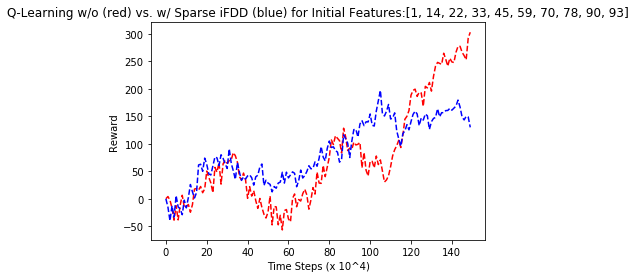

Time Elapsed: 6852.53
Trial: 3
Initial Active Features for Current Trial: [3, 14, 25, 35, 44, 59, 70, 79, 89, 91]
-----------Q-Learning-----------
Len Initial Discovered Set: 10 
Len Initial Undiscovered Set: 1013
Timestep: 0 Time elapsed: 0.01 Cumulative Reward: 0
Timestep: 500000 Time elapsed: 195.11 Cumulative Reward: 149.2374
Timestep: 1000000 Time elapsed: 389.83 Cumulative Reward: 343.9195
Timestep: 1500000 Time elapsed: 582.59 Cumulative Reward: 390.1176
Training Time: 582.59
-----------Q-Learning w/ Sparse iFDD-----------
Len Initial Discovered Set: 10 
Len Initial Undiscovered Set: 1013
Timestep: 0 Elapsed: 0.09 DISCOVERED: 10 UNDISCOVERED: 1013 Basis: 94 Weights: 94 Cumul. Reward: 0
Timestep: 500000 Elapsed: 259.66 DISCOVERED: 10 UNDISCOVERED: 1080 Basis: 94 Weights: 94 Cumul. Reward: 50.9295
Timestep: 1000000 Elapsed: 1044.01 DISCOVERED: 47 UNDISCOVERED: 1147 Basis: 131 Weights: 131 Cumul. Reward: 248.3716
Timestep: 1500000 Elapsed: 5954.29 DISCOVERED: 125 UNDISCOVERED: 1233

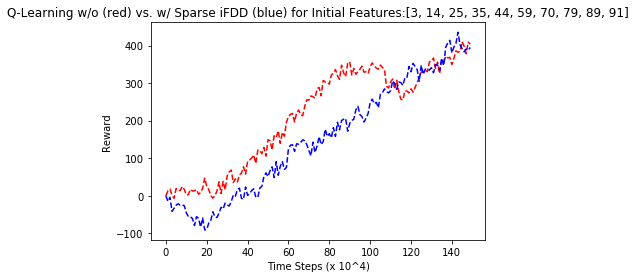

Time Elapsed: 13389.77
Experiment complete!
Total Training Time: 3.72 hours


In [116]:
batchQSiFDDTrain(trials = 3, epsilon = 0.01, episodeLen = 1500000, myDiscoverFrequency = 600)

### Discussion 
In all three trials, Q-Learning w/ Sparse iFDD matches or exceeds Q-Learning alone. In a sense, Sparse iFDD helps tone down the optimism of Q-Learning, which causes the fluctuations and temporary learning roadblocks. 
- In trial 1, vanilla Q-Learning gets stuck and does not learn to locomote forward until at 1,000,000 timesteps, which supports our goal of stabilizing learning by reducing where the function gets "stuck". 
- In trial 2, Q-Learning w/ Sparse iFDD matches Q-Learning until about timestep 1,200,000 after which it increases a little slower. However, this could be due to the larger fluctuations of vanilla Q-Learning, which would observed if the episode length were longer. This result supports our goal of stabilizing learning by reducing sharp increases and decreases. 
- In trial 3, both algorithms more or less match in terms of slope, with vanilla Q-Learning gaining a slight advantage earlier on. It is worth noting that this trial appears to have learnt a near optimal action-value function, since both learning curves appear to increase with little perturbations, as opposed to the other trials.  

Overall, over an episode length of 1,500,000, we obtain preliminary but significant results for comparing the two algorithms. Sparse iFDD appears to stabilize and improve the Q-function when its vanilla version gets stuck, and otherwise being able to match the performance of stable vanilla Q-learning. 

### Future Improvements
Further hyperparameter testing for the discovery frequency and sampling parameters is needed in order to draw more conclusions. More trials are needed in order to support the Sparse iFDD algorithm's reproducibility. It would be interesting to test if the performance of either algorithm is dependent on initial active features, although Sparse iFDD should perform fairly well regardless. 